## Setup

In [1]:
# Import packages
import numpy as np
import time
from datetime import datetime
import json
import random


import torch
import torch.nn as nn
import torch.optim as optim

from torch_geometric.data import HeteroData
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import global_mean_pool, global_max_pool

from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

from tqdm import tqdm
import sys
from pyg_dataset import NetlistDataset

sys.path.append("models/layers/")
from models.model_att import GNN_node

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pickle
import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Get hyperparameters from config file
with open('config.json', 'r') as fh:
    params = json.load(fh)
    test = params['test'] # if only test but not train
    restart = params['restart'] # if restart training
    reload_dataset = params['reload_dataset'] # if reload already processed h_dataset

    if test:
        restart = True

    prediction = params['prediction'] # one of ['congestion', 'demand']
    model_type = params['model_type'] #this can be one of ["dehnn", "dehnn_att", "digcn", "digat"] "dehnn_att" might need large memory usage
    num_layer = params['num_layer'] #large number will cause OOM
    num_dim = params['num_dim'] #large number will cause OOM
    vn = params['vn'] #use virtual node or not
    trans = params['trans'] #use transformer or not
    aggr = params['aggr'] #use aggregation as one of ["add", "max"]
    device = params['device'] #use cuda or cpu
    learning_rate = params['learning_rate'] #rate of gradient descent
    num_epochs = params['num_epochs'] #length of training

if not reload_dataset:
    # open data files
    dataset = NetlistDataset(data_dir="../data/superblue", load_pd = True, load_pe = True, pl = True, processed = reload_dataset, load_indices=None)
    h_dataset = []
    for data in tqdm(dataset):
        # read in node and net features
        num_instances = data.node_features.shape[0]
        data.num_instances = num_instances
        data.edge_index_sink_to_net[1] = data.edge_index_sink_to_net[1] - num_instances
        data.edge_index_source_to_net[1] = data.edge_index_source_to_net[1] - num_instances
        
        out_degrees = data.net_features[:, 0]
        mask = (out_degrees < 3000)
        mask_edges = mask[data.edge_index_source_to_net[1]] 
        filtered_edge_index_source_to_net = data.edge_index_source_to_net[:, mask_edges]
        data.edge_index_source_to_net = filtered_edge_index_source_to_net

        mask_edges = mask[data.edge_index_sink_to_net[1]] 
        filtered_edge_index_sink_to_net = data.edge_index_sink_to_net[:, mask_edges]
        data.edge_index_sink_to_net = filtered_edge_index_sink_to_net

        h_data = HeteroData()
        h_data['node'].x = data.node_features
        h_data['net'].x = data.net_features.float()
        print(data.node_features.shape)

        # Create hypergraph structure
        edge_index = torch.concat([data.edge_index_sink_to_net, data.edge_index_source_to_net], dim=1)
        h_data['node', 'to', 'net'].edge_index, h_data['node', 'to', 'net'].edge_weight = gcn_norm(edge_index, add_self_loops=False)
        h_data['node', 'to', 'net'].edge_type = torch.concat([torch.zeros(data.edge_index_sink_to_net.shape[1]), torch.ones(data.edge_index_source_to_net.shape[1])]).bool()
        h_data['net', 'to', 'node'].edge_index, h_data['net', 'to', 'node'].edge_weight = gcn_norm(edge_index.flip(0), add_self_loops=False)
        
        h_data['design_name'] = data['design_name']
        h_data.num_instances = data.node_features.shape[0]
        variant_data_lst = []

        # Read congestion targets for prediction
        node_congestion = data.node_congestion.long()
        net_congestion = data.net_congestion.long()
        node_demand = data.node_demand.float()
        net_demand = data.net_demand.float()
        # node_demand = (node_demand - torch.mean(node_demand)) / torch.std(node_demand)
        # net_demand = (net_demand - torch.mean(net_demand))/ torch.std(net_demand)
        
        # Create and save processed data
        batch = data.batch
        num_vn = len(np.unique(batch))
        vn_node = torch.concat([global_mean_pool(h_data['node'].x, batch), 
                global_max_pool(h_data['node'].x, batch)], dim=1)

        variant_data_lst.append((node_demand, net_demand, node_congestion, net_congestion, batch, num_vn, vn_node, data.mask)) 
        h_data['variant_data_lst'] = variant_data_lst
        h_dataset.append(h_data)
        
    torch.save(h_dataset, "h_dataset.pt")
    
else:
    dataset = torch.load("h_dataset.pt")
    h_dataset = []
    for data in dataset:
        h_dataset.append(data)
    
sys.path.append("models/layers/")

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized



superblue_19


  8%|███▍                                        | 1/13 [00:01<00:18,  1.52s/it]

superblue_18


 15%|██████▊                                     | 2/13 [00:02<00:16,  1.46s/it]

superblue_16


 23%|██████████▏                                 | 3/13 [00:04<00:16,  1.69s/it]

superblue_11


 31%|█████████████▌                              | 4/13 [00:07<00:18,  2.08s/it]

superblue_6


 46%|████████████████████▎                       | 6/13 [00:10<00:12,  1.72s/it]

superblue_1


 54%|███████████████████████▋                    | 7/13 [00:12<00:11,  1.89s/it]

superblue_7


 62%|███████████████████████████                 | 8/13 [00:16<00:12,  2.48s/it]

superblue_9


 69%|██████████████████████████████▍             | 9/13 [00:19<00:09,  2.48s/it]

superblue_14


 77%|█████████████████████████████████          | 10/13 [00:20<00:06,  2.27s/it]

superblue_2


 85%|████████████████████████████████████▍      | 11/13 [00:23<00:04,  2.42s/it]

superblue_5


 92%|███████████████████████████████████████▋   | 12/13 [00:25<00:02,  2.34s/it]

superblue_3


 25%|███████████                                 | 3/12 [00:00<00:00, 22.98it/s]

torch.Size([495234, 46])
torch.Size([459495, 46])
torch.Size([671284, 46])
torch.Size([923355, 46])


 50%|██████████████████████                      | 6/12 [00:00<00:00, 14.83it/s]

torch.Size([998122, 46])
torch.Size([797938, 46])
torch.Size([1319052, 46])


 67%|█████████████████████████████▎              | 8/12 [00:00<00:00, 11.92it/s]

torch.Size([810812, 46])
torch.Size([604921, 46])
torch.Size([951166, 46])


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 12.13it/s]

torch.Size([727341, 46])
torch.Size([901254, 46])


In [4]:
# define train/validation/test split
load_data_indices = [idx for idx in range(len(h_dataset))]
all_train_indices = load_data_indices[2:]
all_valid_indices = load_data_indices[1:2]
all_test_indices = load_data_indices[0:1]

## Net Demand LightGBM

In [20]:
train_data = lgb.Dataset(X_train[:, :11], label=y_train_reg)
valid_data = lgb.Dataset(X_val[:, :11], label=y_val_reg)
test_data = lgb.Dataset(X_test[:, :11], label=y_test_reg)

In [14]:
start = time.time()
params = {
    "objective": "regression",
    "metric": "rmse",  # Root Mean Squared Error
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "learning_rate": 0.1,
    "num_leaves": 31,  # Controls tree complexity
    "max_depth": 6,
    "feature_fraction": .9,  # Randomly select 80% of features per tree
    "bagging_fraction": 0.8,  # Randomly select 80% of data per tree
    "bagging_freq": 5,  # Perform bagging every 5 iterations
    "verbose": -1,
}
model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data, test_data],
    num_boost_round=500,  # Max trees
)
print(time.time()-start)

26.62075901031494


In [15]:
y_pred = model.predict(X_train[:, :11])
rmse = np.sqrt(mean_squared_error(y_train_reg, y_pred))
print(f"Train RMSE: {rmse}")

y_pred = model.predict(X_test[:, :11])
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
print(f"Test RMSE: {rmse}")

y_pred = model.predict(X_val[:, :11])
rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred))
print(f"Validation RMSE: {rmse}")

Train RMSE: 10.897806754703934
Test RMSE: 13.44896516654689
Validation RMSE: 8.523395710288385


In [16]:
eigenvectors = ["Eigenvector " + str(i) for i in range(10)]
feature_names = ["Degree"] + eigenvectors

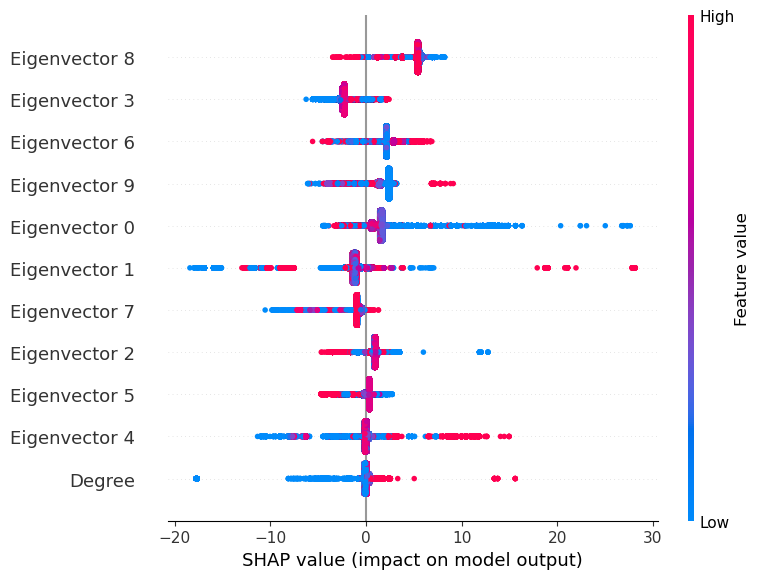

In [17]:
# generate shap values and plot
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test[:,:11])
shap_figure = shap.summary_plot(shap_values, X_test[:,:11], feature_names=feature_names, show=False)
plt.savefig('../results/plots/shap_net.png', bbox_inches='tight', dpi=300)

## Net Demand Random Forest

In [21]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=15)

In [ ]:
start = time.time()
model.fit(X_train[:,:11], y_train_reg)
print(time.time()-start)

resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized



In [ ]:
y_pred = model.predict(X_train[:,:11])
rmse = np.sqrt(mean_squared_error(y_train_reg, y_pred))
print(f"Train RMSE: {rmse}")

y_pred = model.predict(X_test[:,:11])
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
print(f"Test RMSE: {rmse}")

y_pred = model.predict(X_val[:,:11])
rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred))
print(f"Validation RMSE: {rmse}")

## Net Demand LightGBM (with Capacity)

In [6]:
# create tabular dataset by parsing h_dataset
X_train_list = []
y_train_list_r = []
X_val_list = []
y_val_list_r = []
X_test_list = []
y_test_list_r = []

train_idx = all_train_indices
test_idx = all_test_indices
val_idx = all_valid_indices
for i in train_idx:
    X_train_list.append(h_dataset[i]["net"]["x"])
    y_train_list_r.append(h_dataset[i]["variant_data_lst"][0][1])
for i in test_idx:
    X_test_list.append(h_dataset[i]["net"]["x"])
    y_test_list_r.append(h_dataset[i]["variant_data_lst"][0][1])
for i in val_idx:
    X_val_list.append(h_dataset[i]["net"]["x"])
    y_val_list_r.append(h_dataset[i]["variant_data_lst"][0][1])        

In [7]:
X_train = torch.cat(X_train_list, dim=0).numpy()
y_train_reg = torch.cat(y_train_list_r, dim=0).numpy()
X_test = torch.cat(X_test_list, dim=0).numpy()
y_test_reg = torch.cat(y_test_list_r, dim=0).numpy()
X_val = torch.cat(X_val_list, dim=0).numpy()
y_val_reg = torch.cat(y_val_list_r, dim=0).numpy()

In [8]:
# convert to LightGBM objects
train_data = lgb.Dataset(X_train, label=y_train_reg)
valid_data = lgb.Dataset(X_val, label=y_val_reg)
test_data = lgb.Dataset(X_test, label=y_test_reg)

In [9]:
start = time.time()
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "num_leaves": 31, 
    "max_depth": 6,
    "feature_fraction": 1, 
    "bagging_fraction": 0.8,
    "bagging_freq": 5, 
    "verbose": -1,
}
model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data, test_data],
    num_boost_round=500,)
print(time.time()-start)

27.169440031051636


In [ ]:
y_pred = model.predict(X_train[:,:11])
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"Train RMSE: {rmse}")

y_pred = model.predict(X_test[:,:11])
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

y_pred = model.predict(X_val[:,:11])
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse}")

## Node Demand LightGBM (with Capacity)

In [37]:
X_train_list = []
y_train_list = []
X_val_list = []
y_val_list = []
X_test_list = []
y_test_list = []

train_idx = all_train_indices
test_idx = all_test_indices
val_idx = all_valid_indices
for i in train_idx:
    X_train_list.append(h_dataset[i]["node"]["x"])
    y_train_list.append(h_dataset[i]["variant_data_lst"][0][0])
for i in test_idx:
    X_test_list.append(h_dataset[i]["node"]["x"])
    y_test_list.append(h_dataset[i]["variant_data_lst"][0][0])
for i in val_idx:
    X_val_list.append(h_dataset[i]["node"]["x"])
    y_val_list.append(h_dataset[i]["variant_data_lst"][0][0])        

In [38]:
X_train = torch.cat(X_train_list, dim=0).numpy()
y_train = torch.cat(y_train_list, dim=0).numpy()
X_test = torch.cat(X_test_list, dim=0).numpy()
y_test = torch.cat(y_test_list, dim=0).numpy()
X_val = torch.cat(X_val_list, dim=0).numpy()
y_val = torch.cat(y_val_list, dim=0).numpy()

In [39]:
train_data = lgb.Dataset(X_train[:,:45], label=y_train)
valid_data = lgb.Dataset(X_val[:,:45], label=y_val)
test_data = lgb.Dataset(X_test[:,:45], label=y_test)

In [40]:
start = time.time()
params = {
    "objective": "regression",
    "metric": "rmse",  # Root Mean Squared Error
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "learning_rate": 0.1,
    "num_leaves": 31,  # Controls tree complexity
    "max_depth": 6,  # No depth limit
    "feature_fraction": 1,  # Randomly select 80% of features per tree
    "bagging_fraction": 0.8,  # Randomly select 80% of data per tree
    "bagging_freq": 5,  # Perform bagging every 5 iterations
    "verbose": -1,
}
model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data, test_data],
    num_boost_round=500,  # Max trees
)
print(time.time()-start)

40.44880294799805


In [41]:
y_pred = model.predict(X_train[:,:45])
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"Train RMSE: {rmse}")

y_pred = model.predict(X_test[:,:45])
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

y_pred = model.predict(X_val[:,:45])
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse}")

Train RMSE: 10.049663799381937
Test RMSE: 11.001176090976442
Validation RMSE: 10.605050018803352


In [42]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test[:,:45])

In [43]:
cell_features = ["Type", "Width", "Height", "Orientation", "Degree"]
eigenvectors = ["Eigenvector " + str(i) for i in range(10)]
pd_in = ["PD Inflow " + str(i) for i in range(9)]
pd_out = ["PD Outflow " + str(i) for i in range(9)]
degree_in = ["Degree Distribution Inflow " + str(i) for i in range(6)]
degree_out = ["Degree Distribution Outflow " + str(i) for i in range(6)]
feature_names = cell_features + eigenvectors + pd_in + pd_out + degree_in + degree_out

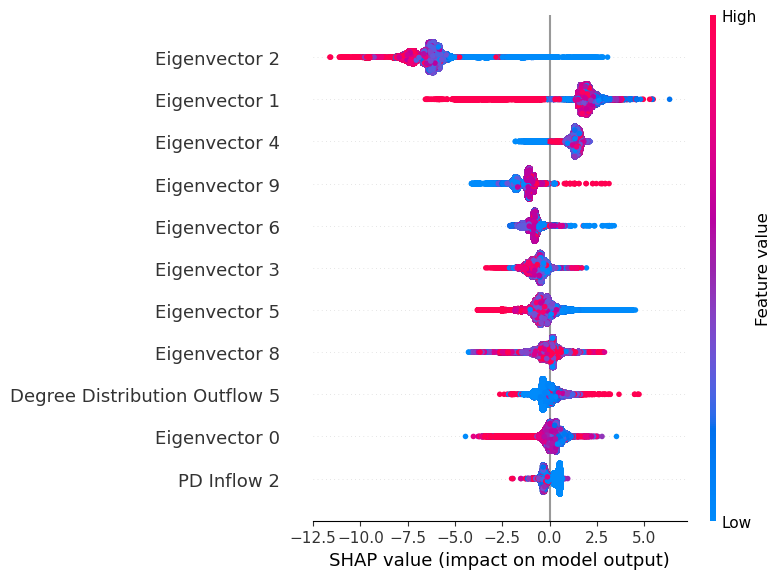

In [45]:
shap_figure = shap.summary_plot(shap_values, X_test[:,:45], feature_names=feature_names, show=False, max_display=11)
plt.savefig('../results/plots/shap_node.png', bbox_inches='tight', dpi=300)

## Train/Test Split Grid Search

In [112]:
results = {"test index":[], "validation index":[], "train RMSE":[], "test RMSE":[], "validation RMSE":[]}
for i in range(12):
    for j in range(i+1, 12):
        print((i,j))
        results["test index"].append(i)
        results["validation index"].append(j)
        load_data_indices = [idx for idx in range(len(h_dataset))]
        all_train_indices = [x for x in range(12) if x not in [i,j]]
        all_valid_indices = [load_data_indices[i]]
        all_test_indices = [load_data_indices[j]]

        X_train_list = []
        y_train_list_r = []
        X_val_list = []
        y_val_list_r = []
        X_test_list = []
        y_test_list_r = []
        
        train_idx = all_train_indices
        test_idx = all_test_indices
        val_idx = all_valid_indices
        for i in train_idx:
            X_train_list.append(h_dataset[i]["net"]["x"])
            y_train_list_r.append(h_dataset[i]["variant_data_lst"][0][1])
        for i in test_idx:
            X_test_list.append(h_dataset[i]["net"]["x"])
            y_test_list_r.append(h_dataset[i]["variant_data_lst"][0][1])
        for i in val_idx:
            X_val_list.append(h_dataset[i]["net"]["x"])
            y_val_list_r.append(h_dataset[i]["variant_data_lst"][0][1])    

        X_train = torch.cat(X_train_list, dim=0).numpy()
        y_train_reg = torch.cat(y_train_list_r, dim=0).numpy()
        X_test = torch.cat(X_test_list, dim=0).numpy()
        y_test_reg = torch.cat(y_test_list_r, dim=0).numpy()
        X_val = torch.cat(X_val_list, dim=0).numpy()
        y_val_reg = torch.cat(y_val_list_r, dim=0).numpy()

        
        train_data = lgb.Dataset(X_train, label=y_train_reg)
        valid_data = lgb.Dataset(X_val, label=y_val_reg)
        test_data = lgb.Dataset(X_test, label=y_test_reg)

        start = time.time()
        params = {
            "objective": "regression",
            "metric": "rmse",  # Root Mean Squared Error
            "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
            "learning_rate": 0.1,
            "num_leaves": 31,  # Controls tree complexity
            "max_depth": 6,  # No depth limit
            "feature_fraction": 1,  # Randomly select 80% of features per tree
            "bagging_fraction": 0.8,  # Randomly select 80% of data per tree
            "bagging_freq": 5,  # Perform bagging every 5 iterations
            "verbose": -1,
        }
        model = lgb.train(
            params,
            train_data,
            valid_sets=[valid_data, test_data],
            num_boost_round=500,  # Max trees
        )
        print(time.time()-start)

        y_pred = model.predict(X_train)
        rmse = np.sqrt(mean_squared_error(y_train_reg, y_pred))
        results["train RMSE"].append(rmse)
        
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
        results["test RMSE"].append(rmse)
        
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred))
        results["validation RMSE"].append(rmse)
            

(0, 1)
28.622649908065796
(0, 2)
29.413767099380493
(0, 3)
28.702486991882324
(0, 4)
28.141061305999756
(0, 5)
27.948693990707397
(0, 6)
27.55571413040161
(0, 7)
28.650174856185913
(0, 8)
29.40016222000122
(0, 9)
28.55621600151062
(0, 10)
29.474830865859985
(0, 11)
28.907474756240845
(1, 2)
28.999845027923584
(1, 3)
29.127599239349365
(1, 4)
28.25607991218567
(1, 5)
29.13117790222168
(1, 6)
28.2487690448761
(1, 7)
28.666558980941772
(1, 8)
29.544349908828735
(1, 9)
29.031475067138672
(1, 10)
29.506609201431274
(1, 11)
28.95117998123169
(2, 3)
28.34676718711853
(2, 4)
27.95088505744934
(2, 5)
28.473118782043457
(2, 6)
27.1818790435791
(2, 7)
28.91991686820984
(2, 8)
28.629669189453125
(2, 9)
28.894102096557617
(2, 10)
30.03563904762268
(2, 11)
28.60430908203125
(3, 4)
28.546946048736572
(3, 5)
28.205655097961426
(3, 6)
27.175933122634888
(3, 7)
28.498178243637085
(3, 8)
28.851256132125854
(3, 9)
28.160014867782593
(3, 10)
28.736536979675293
(3, 11)
28.316272020339966
(4, 5)
28.476963043

In [116]:
results_df = pd.DataFrame(results)

(array([ 1.,  0.,  0.,  1.,  0.,  6.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  6.,  6.,  5., 10., 20.,  7.]),
 array([ 5.70954496,  5.96448725,  6.21942953,  6.47437182,  6.7293141 ,
         6.98425639,  7.23919867,  7.49414096,  7.74908324,  8.00402552,
         8.25896781,  8.51391009,  8.76885238,  9.02379466,  9.27873695,
         9.53367923,  9.78862151, 10.0435638 , 10.29850608, 10.55344837,
        10.80839065]),
 <BarContainer object of 20 artists>)

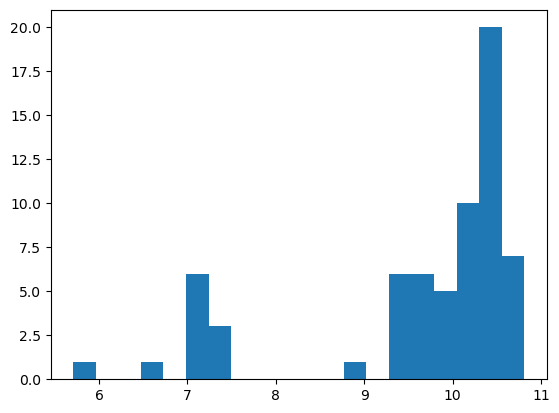

In [121]:
plt.hist(results_df["train RMSE"], bins=20)

(array([ 6., 17., 22.,  3.,  1.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  3.,  0.,  1.,  3.,  6.]),
 array([ 4.76547482,  6.48891726,  8.2123597 ,  9.93580214, 11.65924458,
        13.38268702, 15.10612946, 16.82957189, 18.55301433, 20.27645677,
        21.99989921, 23.72334165, 25.44678409, 27.17022653, 28.89366897,
        30.6171114 , 32.34055384, 34.06399628, 35.78743872, 37.51088116,
        39.2343236 ]),
 <BarContainer object of 20 artists>)

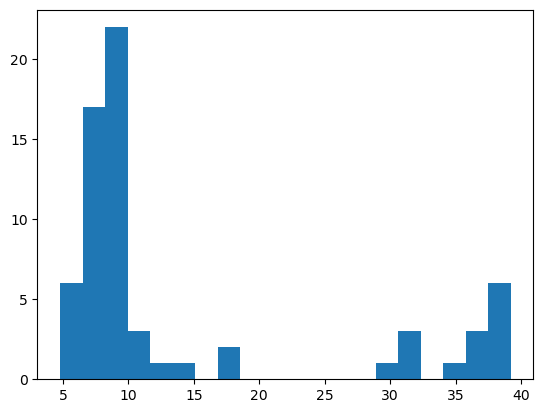

In [120]:
plt.hist(results_df["test RMSE"], bins=20)

(array([12., 18., 13.,  6.,  0.,  3.,  5.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  4.,  3.,  0.,  0.,  0.,  1.]),
 array([ 4.98557878,  6.6532135 ,  8.32084821,  9.98848292, 11.65611763,
        13.32375235, 14.99138706, 16.65902177, 18.32665648, 19.99429119,
        21.66192591, 23.32956062, 24.99719533, 26.66483004, 28.33246476,
        30.00009947, 31.66773418, 33.33536889, 35.00300361, 36.67063832,
        38.33827303]),
 <BarContainer object of 20 artists>)

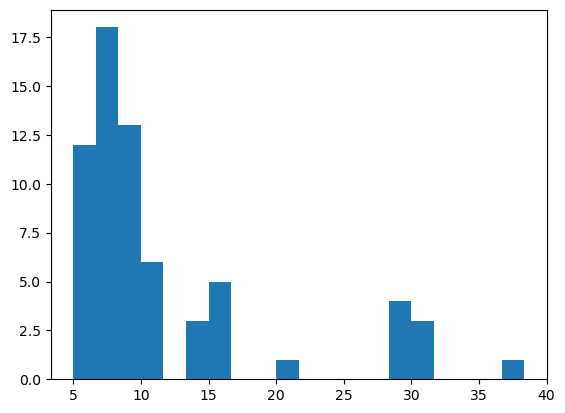

In [122]:
plt.hist(results_df["validation RMSE"], bins=20)

In [10]:
# predict on train/validation/test data
y_pred = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train_reg, y_pred))
print(f"Train RMSE: {rmse}")

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
print(f"Test RMSE: {rmse}")

y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val_reg, y_pred))
print(f"Validation RMSE: {rmse}")

Train RMSE: 10.19326440136293
Test RMSE: 7.855638837659586
Validation RMSE: 5.9780222256231585
